### Main Config

In [1]:
Data_path = "/content/drive/MyDrive/Behavioral/Data"
Models_path = "/content/drive/MyDrive/Behavioral/Models"

### Google Colab Configs

In [2]:
%%capture
!pip uninstall -y pandas numpy scipy
!pip install pandas scipy==1.10.1

In [3]:
# Colab Config

%%capture
!pip install emoji
!pip install langdetect
!pip install nltk
!pip install tqdm
!pip install langid
!pip install scipy==1.10.1
!pip install genism
!pip install pyLDAvis==3.4.1

from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# Project

In [5]:
random_seed = 42
notebook_env = "test" # "test" for experimenting, "final" for final execution

In [6]:
import kagglehub
import os
import json
import pandas as pd
import spacy
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import emoji
import re
from langdetect import detect, detect_langs
import nltk
import string
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm
import langid
from ast import pattern
tqdm.pandas()

In [7]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Download Data from Kaggle/Load Data

In [8]:
dataset_name = "10Mar2025.json"
dataset_path = os.path.join(Data_path, dataset_name)

if os.path.isfile(dataset_path):
  with open(dataset_path, 'r') as f:
    data = json.load(f)
  print("Dataset loaded from drive.")
else:
  fort_list_path = kagglehub.dataset_download("jeannicolasduval/2024-fortune-1000-companies")
  print("Dataset downloaded from kaggle.")

  # Load the wanted file
  temp_path = os.path.join(fort_list_path, "10Mar2025.json")
  data = pd.read_json(temp_path)

  # Save the data into drive
  data.to_json(dataset_path)
  print("Dataset saved to drive.")

  # The complementary Dataset
dataset_name = "fortune1000_2024.csv.csv"
dataset_path = os.path.join(Data_path, dataset_name)

if os.path.isfile(dataset_path):
  fortune_company_list = pd.read_csv(dataset_path)
  print("Dataset loaded from drive.")
else:
  fort_list_path = kagglehub.dataset_download("jeannicolasduval/2024-fortune-1000-companies")
  print("Dataset downloaded from kaggle.")
  fortune_company_list = pd.read_csv(os.path.join(fort_list_path, "fortune1000_2024.csv"))
  fortune_company_list.to_csv(dataset_path)
  print("Dataset saved to drive.")

Dataset loaded from drive.
Dataset loaded from drive.


In [9]:
fortune_company_list.head()

,Unnamed: 0,Rank,Company,Ticker,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs,...,Assets_M,CEO,Country,HeadquartersCity,HeadquartersState,Website,CompanyType,Footnote,MarketCap_Updated_M,Updated
0,0,1,Walmart,WMT,Retailing,General Merchandisers,yes,no,no,no,...,252399.0,C. Douglas McMillon,U.S.,Bentonville,Arkansas,https://www.stock.walmart.com,Public,"Figures are for fiscal year ended Jan. 31, 202...",559911.0,2024-08-05
1,1,2,Amazon,AMZN,Retailing,Internet Services and Retailing,yes,no,no,no,...,527854.0,Andrew R. Jassy,U.S.,Seattle,Washington,https://www.amazon.com,Public,"Market value as of July 15, 2024.",2005565.0,2024-08-05
2,2,3,Apple,AAPL,Technology,"Computers, Office Equipment",yes,no,no,no,...,352583.0,Timothy D. Cook,U.S.,Cupertino,California,https://www.apple.com,Public,"Figures are for fiscal year ended Sept. 30, 20...",3594309.0,2024-08-05
3,3,4,UnitedHealth Group,UNH,Health Care,Health Care: Insurance and Managed Care,yes,no,no,yes,...,273720.0,Andrew P. Witty,U.S.,Minnetonka,Minnesota,https://www.unitedhealthgroup.com,Public,"Market value as of July 15, 2024.",474339.0,2024-08-05
4,4,5,Berkshire Hathaway,BRKA,Financials,Insurance: Property and Casualty (Stock),yes,no,no,yes,...,1069978.0,Warren E. Buffett,U.S.,Omaha,Nebraska,https://www.berkshirehathaway.com,Public,"Market value as of July 15, 2024.",937028.0,2024-08-05


In [10]:
data[0].keys()

dict_keys(['company', 'rank', 'timestamp', 'tweets', 'posts', 'comments', 'metadata'])

In [11]:
columns = ["Company", "Text", "Source"]
atts_temp = ["tweets", "comments", "posts"]
source_dic = {"tweets": "Twitter", "comments": "Reddit-Comments", "posts": "Reddit-Posts"}
mp_doc_list = []

for company in data:
  for text_list in atts_temp:
    if text_list in company:
      for text in company[text_list]:
        mp_doc_list.append([company["company"], text["text"], source_dic[text_list]])


data_df = pd.DataFrame(mp_doc_list, columns=columns)
data_df

,Company,Text,Source
0,Walmart,$GOOGL $GOOG $WMT Google And Walmart Payment A...,Twitter
1,Walmart,Can $PHNIX become the first meme coin to dethr...,Twitter
2,Walmart,"Walmart $WMT \n\nThe Laughing Cow Cheese, 32 p...",Twitter
3,Walmart,Some of the most iconic businesses ever \n\n1....,Twitter
4,Walmart,Walmart $WMT currently has 1.05 Billion Square...,Twitter
...,...,...,...
591342,Clear Channel Outdoor Hldgs.,Hi BUB Sub!\n\n\nHad this account on the back ...,Reddit-Posts
591343,Clear Channel Outdoor Hldgs.,I am curious how these events typically play o...,Reddit-Posts
591344,Clear Channel Outdoor Hldgs.,,Reddit-Posts
591345,Clear Channel Outdoor Hldgs.,The Role of the National Weather Service in Em...,Reddit-Posts


In [12]:
enriched_data = pd.merge(fortune_company_list[["Company", "Ticker", "Sector", "Industry"]], data_df, left_on="Company", right_on="Company")
enriched_data.sample(10, random_state=random_seed)

,Company,Ticker,Sector,Industry,Text,Source
233120,BlackRock,BLK,Financials,Securities,You do understand that BlackRock buys the shar...,Reddit-Comments
420124,Hubbell,HUBB,Industrials,"Electronics, Electrical Equip.",,Reddit-Posts
221548,Adobe,ADBE,Technology,Computer Software,Your post is about Monkrus.\n\nMonkrus has no ...,Reddit-Comments
169118,Cummins,CMI,Industrials,Industrial Machinery,Hayden\n\nLanger\n\nPonting\n\nSmith\n\nClarke...,Reddit-Comments
88967,RTX,RTX,Aerospace & Defense,Aerospace & Defense,"You posted wrong links for stuff, double check...",Reddit-Comments
99040,HCA Healthcare,HCA,Health Care,Health Care: Medical Facilities,I work at an HCA hospital. We're a private EM ...,Reddit-Comments
469693,Splunk,NaN,Technology,Computer Software,"Over the past year, my org has moved from Splu...",Reddit-Posts
419354,Mattel,MAT,Household Products,"Toys, Sporting Goods",As Title!🙏\n\nPls genuine answer dena !!\n,Reddit-Posts
85860,Boeing,BA,Aerospace & Defense,Aerospace & Defense,These 757 planes and engines are all really ol...,Reddit-Comments
114387,Allstate,ALL,Financials,Insurance: Property and Casualty (Stock),The problem is exactly the people who consider...,Reddit-Comments


In [13]:
# compare unique companies in the enriched dataset and main dataset
enriched_companies = enriched_data["Company"].unique()
main_companies = data_df["Company"].unique()

print(f"Number of companies in the enriched dataset: {len(enriched_companies)}")
print(f"Number of companies in the main dataset: {len(main_companies)}")

Number of companies in the enriched dataset: 953
Number of companies in the main dataset: 953


In [14]:
data_df = enriched_data

In [15]:
# enriched_data_name = "enriched_companyData_complete.csv"
# enriched_data_path = os.path.join(Data_path, enriched_data_name)
# enriched_data.to_csv(os.path.join(Data_path, "enriched_companyData_complete.csv"))

## Preprocessing the texts

In [16]:
data_df.describe()

,Company,Ticker,Sector,Industry,Text,Source
count,591347,579881,591347,591347,591347,591347
unique,953,932,21,75,487445,3
top,Tesla,TSLA,Technology,Internet Services and Retailing,,Reddit-Posts
freq,9438,9438,132908,60577,82315,329493


In [17]:
# show duplicates
data_df[data_df.duplicated()].sample(10)

,Company,Ticker,Sector,Industry,Text,Source
128241,HP,HPQ,Technology,"Computers, Office Equipment",,Reddit-Posts
409668,Pool,POOL,Wholesalers,Wholesalers: Diversified,,Reddit-Posts
566291,Guess,GES,Retailing,Specialty Retailers: Apparel,,Reddit-Posts
526961,Coinbase Global,COIN,Financials,Securities,,Reddit-Posts
316243,Ebay,EBAY,Technology,Internet Services and Retailing,,Reddit-Posts
31769,Microsoft,MSFT,Technology,Computer Software,,Reddit-Posts
225935,Fiserv,FI,Business Services,Financial Data Services,,Reddit-Posts
584075,Universal,UVV,"Food, Beverages & Tobacco",Tobacco,,Reddit-Posts
72834,Tesla,TSLA,Motor Vehicles & Parts,Motor Vehicles & Parts,,Reddit-Posts
174049,Netflix,NFLX,Media,Entertainment,,Reddit-Posts


In [18]:
dataset_name = "complete_preprocessed_companyData.csv"
dataset_path = os.path.join(Data_path, dataset_name)

if os.path.isfile(dataset_path):
  temp_df = pd.read_csv(dataset_path)
  print("Dataset loaded from drive.")
else:
  # drop duplicates
  data_df = data_df.drop_duplicates()
  data_df.describe()


  ### Sample for Analysis
  # **Sampling of Enriched Data**: This is done to make experiments lighter, for final analysis all data will be used.
  if notebook_env == "test":
    sample_data_df = data_df.sample(50000, random_state=random_seed)
  elif notebook_env == "final":
    sample_data_df = data_df.copy()

  def preprocess_text(text, index, targets):

    # First Demojize Text
    edited_text = emoji.replace_emoji(text, '')

    # Mask company
    try:
      pattern = r'(?<![a-zA-Z])(?:' + '|'.join(re.escape(word) for word in targets if isinstance(word, str)) + r')(?![a-zA-Z])'
      if re.search(pattern, text, flags=re.IGNORECASE):
          edited_text = re.sub(pattern, "TargetedCompany", text, flags=re.IGNORECASE)
      else:
          edited_text = ""

    except Exception as e:
      raise

    # lower case
    edited_text = edited_text.lower()

    # remove links, mentions, hashtags
    edited_text = re.sub(r"http\S+|www\S+|@\w+|#\w+", '', edited_text)

    # Remove numbers
    edited_text = re.sub(r'\d+', '', edited_text)

    # Remove non ASCII
    edited_text = re.sub(r'[^\x00-\x7F]+', '', edited_text)

    # remove extra spaces
    edited_text = re.sub(r'\s+', ' ', edited_text).strip()

    # return if text is empty
    if edited_text == "":
      return edited_text

    # Remove non english
    try:
      # lang = detect(edited_text)
      lang, _ = langid.classify(edited_text)
      if lang != "en":
          edited_text = ""
    except Exception as e:
      # print(f"Error detecting language for text at index {index} and content:{edited_text}: {e}")
      edited_text = ""

    return edited_text

  temp_df = sample_data_df.copy()
  temp_df["Text"] = temp_df.progress_apply(lambda row: preprocess_text(row["Text"], row.name, [row["Company"], row["Ticker"]]), axis=1)
  temp_df

  temp_df = temp_df[temp_df["Text"] != ""]
  temp_df.describe()

  temp_df.to_csv(dataset_path)


Dataset loaded from drive.


In [19]:
temp_df.head()

,Unnamed: 0,Company,Ticker,Sector,Industry,Text,Source
0,52944,Comcast,CMCSA,Telecommunications,Telecommunications,same thing happened to me this week. police de...,Reddit-Comments
1,143656,Dow,DOW,Chemicals,Chemicals,> stock futures tumbled sunday night to kick o...,Reddit-Posts
2,525390,Sinclair,SBGI,Media,Entertainment,"got some big names in the mid and fwd, feel my...",Reddit-Posts
3,374514,Olin,OLN,Chemicals,Chemicals,not full true! i was playing with targetedcomp...,Reddit-Comments
4,178759,3M,MMM,Chemicals,Chemicals,this storm had to be some kind of divine punis...,Reddit-Posts


## Vectorization and Lemmatization

In [20]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
target_filter = "targetedcompany"
nlp_pip = spacy.load("en_core_web_sm")

def tokenize_text(text):

  # tokenize with NLTK
  doc = nlp_pip(text)

  # remove punct and stopwords and targetCompany
  tokens = []
  for token in doc:
    if (not token.is_punct) and (not token.is_stop) and (token.text != target_filter):
      tokens.append(token.lemma_)

  return tokens

In [21]:
# # tesing the tokenization
# sample = temp_df.sample(random_state=random_seed, n= 100)[["Text"]]
# sample["Tokens"] = sample[["Text"]].apply(lambda row: tokenize_text(row["Text"]), axis=1)
# sample

In [22]:
# def print_tokenization(row):
#   test = textwrap.fill(row["Text"], width=150)
#   tokenized = textwrap.fill(", ".join(row["Tokens"]), width=150)
#   print(f"Main text: {test}, \n **************** \nTokenized Text: {tokenized}\n")


# sample.apply(lambda row: print_tokenization(row), axis=1)

In [23]:
dataset_name = "spacy_tokenized_sample.pkl"
dataset_path = os.path.join(Data_path, dataset_name)

if os.path.isfile(dataset_path):
  tokenized_texts = pd.read_pickle(dataset_path)
  print("Loaded from drive.")
else:
  tokenized_texts = temp_df.progress_apply(lambda row: tokenize_text(row["Text"]), axis=1)
  tokenized_texts.to_pickle(dataset_path)
  print("Saved to drive.")

Loaded from drive.


In [24]:
def identical_analyzer(token):
  return token

vectorizer = CountVectorizer(analyzer=identical_analyzer, min_df=0.005, max_df=0.995)
bow = vectorizer.fit_transform(tokenized_texts)

In [25]:
vectorizer.get_feature_names_out()[:100]

array(['$', '+', '<', '=', '>', 'ability', 'able', 'absolute',
       'absolutely', 'accept', 'access', 'accord', 'account', 'accurate',
       'achieve', 'acquire', 'act', 'action', 'active', 'activity',
       'actual', 'actually', 'ad', 'add', 'addition', 'additional',
       'address', 'adjust', 'administration', 'admit', 'adult', 'advance',
       'advanced', 'advantage', 'advice', 'affect', 'afford', 'afraid',
       'age', 'agency', 'agent', 'ago', 'agree', 'ahead', 'ai', 'aim',
       'air', 'alert', 'align', 'allow', 'alternative', 'amazing',
       'amazon', 'amd', 'america', 'american', 'analysis', 'analyst',
       'and/or', 'animal', 'announce', 'annoying', 'annual', 'answer',
       'anti', 'anticipate', 'anxiety', 'anybody', 'anymore', 'anyways',
       'apart', 'apartment', 'app', 'apparently', 'appear', 'apple',
       'application', 'apply', 'appointment', 'appreciate', 'approach',
       'approve', 'april', 'area', 'arm', 'arrive', 'art', 'article',
       'artist', 

In [26]:
len(vectorizer.vocabulary_)

1622

In [27]:
# dict of terms and their frequencies
term_frequencies = {}
feats = vectorizer.get_feature_names_out()
freqs = bow.toarray().sum(axis=0)

for feature, frequency in zip(feats, freqs):
  term_frequencies[feature] = frequency

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(term_frequencies)

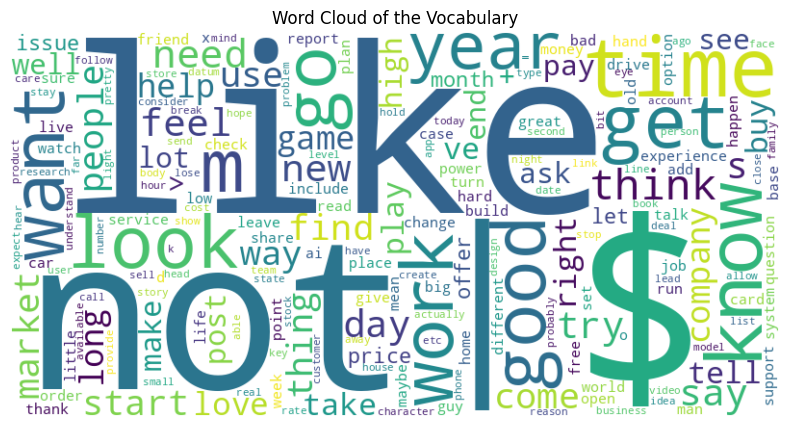

In [28]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud of the Vocabulary")
plt.show()

In [29]:
print(f"Shape of the BOW: {bow.shape}")
print(f"Number of non-zero values: {bow.nnz}")

Shape of the BOW: (35192, 1622)
Number of non-zero values: 967164


In [30]:
tf_idf = TfidfTransformer()

In [31]:
tf_idf_text = tf_idf.fit_transform(bow)

In [32]:
tf_idf_text.shape

(35192, 1622)

## Topic Modeling The texts
Initially, we need to understand what sort of content we have. This will help deciding if we should go with data based topics or anchored topics.

In [33]:
!pip install gensim==4.3.2
!pip install scipy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 69.1 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.3
    Uninstalling gensim-4.3.3:
      Successfully uninstalled gensim-4.3.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [34]:
from gensim.models import CoherenceModel, LdaModel, HdpModel
from gensim.corpora import Dictionary, BleiCorpus

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [35]:
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [36]:
topic_counts = range(2,30,2)

In [38]:
models = []
c_v_coherence = []

for i in tqdm(topic_counts):
  # check if model is already in drive
  model_path_temp = os.path.join(Models_path, "GensimLdaModel_SpacyTokens_TopicCount" + str(i))

  if os.path.isfile(model_path_temp):
    lda_model = LdaModel.load(model_path_temp)
  else:
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=i,
        random_state=random_seed,
        passes=10,
        iterations=50
    )

    # save the trained model
    lda_model.save(model_path_temp)

  # append the model to a list
  models.append(lda_model)


  cm = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
  c_v_coherence.append(cm.get_coherence())

metrics = pd.DataFrame({"Topic_Count": list(topic_counts), "c_v": c_v_coherence})
metrics.head()

100%|██████████| 14/14 [1:06:09<00:00, 283.51s/it]


,Topic_Count,c_v
0,2,0.500264
1,4,0.477012
2,6,0.540062
3,8,0.508027
4,10,0.531092


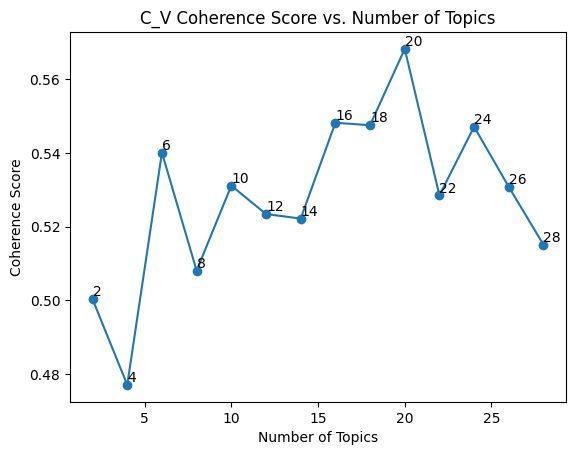

In [39]:
# plot coherence by the topic count
import matplotlib.pyplot as plt

plt.plot(metrics["Topic_Count"], metrics["c_v"], marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('C_V Coherence Score vs. Number of Topics')

for i, txt in enumerate(metrics["Topic_Count"]):
  plt.text(metrics["Topic_Count"][i], metrics["c_v"][i], f'{txt}', ha='left', va='bottom') # Format label to 2 decimal places


In [42]:
pyLDAvis.enable_notebook()
top_model_index = metrics[metrics["Topic_Count"] == 20].index[0]
pyLDAvis.gensim.prepare(models[top_model_index], corpus, dictionary, mds="mmds", R=50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.334645 -0.210034       1        1  23.774342
13    -0.411037 -0.077492       2        1   9.721628
2     -0.233937 -0.086306       3        1   8.385900
12    -0.008503 -0.201855       4        1   6.705289
15    -0.116909  0.155319       5        1   6.277371
14    -0.049828 -0.024672       6        1   5.143448
4     -0.393505  0.103362       7        1   4.716994
18    -0.209537 -0.317424       8        1   4.662558
0     -0.056661 -0.384348       9        1   4.449271
3      0.099255 -0.370731      10        1   4.401185
5      0.233907 -0.285496      11        1   3.113049
10     0.129262  0.268026      12        1   3.107106
19    -0.278444  0.297879      13        1   2.794854
9      0.208212 -0.010138      14        1   2.539868
8     -0.115833  0.459430      15        1   2.517323
6      0.030343  0.384697      16        1   2.473459
16     0.371725 -0.183772      17        1   2.093308
1      0.443116  0.001952      18        1   1.274584
11     0.371711  0.161534      19        1   1.169122
17     0.321308  0.320068      20        1   0.679343, topic_info=         Term          Freq         Total Category  logprob  loglift
959         $  21015.000000  21015.000000  Default  50.0000  50.0000
3910        |  11402.000000  11402.000000  Default  49.0000  49.0000
659       not  15914.000000  15914.000000  Default  48.0000  48.0000
1837   market   5605.000000   5605.000000  Default  47.0000  47.0000
1134        +   3900.000000   3900.000000  Default  46.0000  46.0000
...       ...           ...           ...      ...      ...      ...
1124  walmart     63.815399    194.546535  Topic20  -5.5079   3.8771
298     limit     93.391789   1101.164751  Topic20  -5.1270   2.5245
505   vanilla     57.849399    141.094499  Topic20  -5.6060   4.1002
1233   credit     71.662031   1448.790468  Topic20  -5.3919   1.9853
2856     rare     55.435309    254.634344  Topic20  -5.6486   3.4672

[2214 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
959        5  0.198375        $
959       12  0.003378        $
959       15  0.798211        $
1134       4  0.006409        +
1134       5  0.002051        +
...      ...       ...      ...
3910      15  0.999907        |
4439      15  0.989848  |:-|:-|
12993     14  0.992818      |ye
12994     14  0.982420     |yes
2494      17  0.991722       ||

[5564 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 14, 3, 13, 16, 15, 5, 19, 1, 4, 6, 11, 20, 10, 9, 7, 17, 2, 12, 18])

In [ ]:
lda_model = LdaModel(
      corpus=corpus,
      id2word=dictionary,
      num_topics=5,
      random_state=random_seed,
      passes=10,
      iterations=100
  )

In [ ]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-1.98819942508226

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds="mmds", R=30)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.083159  0.254806       1        1  41.122639
1     -0.119870  0.083361       2        1  25.011465
2     -0.231175 -0.187119       3        1  15.438340
3      0.136970 -0.235810       4        1  10.405512
4      0.297233  0.084761       5        1   8.022044, topic_info=         Term          Freq         Total Category  logprob  loglift
64         wa  28196.000000  28196.000000  Default  30.0000  30.0000
2099   market   5003.000000   5003.000000  Default  29.0000  29.0000
83       game   4263.000000   4263.000000  Default  28.0000  28.0000
308        im  15576.000000  15576.000000  Default  27.0000  27.0000
765   company   4805.000000   4805.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2046    white    376.863610   1079.366786   Topic5  -6.3072   1.4707
2690     case    404.082140   2210.066114   Topic5  -6.2375   0.8238
1056     area    384.304159   1457.498073   Topic5  -6.2877   1.1899
1924   review    371.235813   1155.013108   Topic5  -6.3223   1.3879
125      best    374.029063   3168.665315   Topic5  -6.3148   0.3862

[400 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1111      1  0.002536  account
1111      2  0.984974  account
1111      3  0.012173  account
5118      2  0.995259    admin
1508      2  0.114825       ai
...     ...       ...      ...
616       1  0.264979      yes
616       2  0.239615      yes
616       4  0.009714      yes
616       5  0.485166      yes
4071      5  0.996930     yung

[793 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [ ]:
# Map topic index to a descriptive title
topic_titles = {
    0: "Casual Online Chatter",
    1: "Book or Media Reviews",
    2: "Consumer Goods / Retail",
    3: "Finance & Business News",
    4: "Job Applications & Recruitment",
    5: "Tech Support & Software Use"
}


In [ ]:
import matplotlib.pyplot as plt

# Count topics
topic_counts = temp_df["Topic"].value_counts().sort_index()

# Map the index to topic titles for labeling
labels = [topic_titles[i] for i in topic_counts.index]

# Plot with titles as x-axis labels
plt.figure(figsize=(10, 6))
plt.bar(labels, topic_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Document Counts per Topic")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Group data by sector and topic, and count occurrences
sector_topic_counts = temp_df.groupby(['Sector', 'Topic'])['Topic'].count().unstack()

# Get sector and topic labels
sectors = sector_topic_counts.index
topic_labels = [topic_titles[i] for i in range(lda.n_components)]

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each topic within each sector
bottom = [0] * len(sectors)  # Initialize bottom for stacking
for i, topic_label in enumerate(topic_labels):
    ax.bar(sectors, sector_topic_counts[i], label=topic_label, bottom=bottom)
    bottom = [bottom[j] + sector_topic_counts[i][j] for j in range(len(sectors))]

# Set chart labels and formatting
ax.set_xlabel("Sector")
ax.set_ylabel("Number of Documents")
ax.set_title("Topic Distribution Across Sectors")
ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named 'temp_df' and contains 'Source' and 'Topic' columns

# Group data by source and topic, and count occurrences
source_topic_counts = temp_df.groupby(['Source', 'Topic'])['Topic'].count().unstack()

# Get source and topic labels
sources = source_topic_counts.index
topic_labels = [topic_titles[i] for i in range(lda.n_components)]  # Assuming you have topic_titles defined

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each topic within each source
bottom = [0] * len(sources)  # Initialize bottom for stacking
for i, topic_label in enumerate(topic_labels):
    ax.bar(sources, source_topic_counts[i], label=topic_label, bottom=bottom)
    bottom = [bottom[j] + source_topic_counts[i][j] for j in range(len(sources))]

# Set chart labels and formatting
ax.set_xlabel("Source")
ax.set_ylabel("Number of Documents")
ax.set_title("Topic Distribution Across Sources")
ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a dictionary to store the word clouds for each topic
topic_wordclouds = {}

# Iterate through each topic
for topic_index in range(lda.n_components):
    # Get documents belonging to the current topic
    topic_documents = temp_df[temp_df["Topic"] == topic_index]["Text"]

    # Create a frequency dictionary for words in the topic documents
    word_frequencies = {}
    for doc in topic_documents:
        for word in tokenize_text(doc):  # Use your tokenize_text function
            if word in feature_names:
                word_frequencies[word] = word_frequencies.get(word, 0) + 1

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_frequencies)

    # Store the word cloud in the dictionary
    topic_wordclouds[topic_index] = wordcloud

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_index}: {topic_titles[topic_index]}")  # Assuming you have topic_titles
    plt.show()
